In [ ]:
%reset -f

# Importing Libraries and data

In [103]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from typing import List, Tuple
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score, log_loss, average_precision_score
from sklearn.model_selection import ParameterSampler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from IPython.display import display

In [10]:
DATA_PATH = Path("../../..").resolve()

df = pd.read_csv(Path(DATA_PATH, "feature_frame.csv"))

# Preprocessing from MODULE 3

In [12]:
info_columns = ["variant_id", "order_id", "user_id", "created_at", "order_date"]
target = "outcome"
features_cols = [
    col for col in df.columns if col not in info_columns and col != target
]
categorical_cols = ["product_type", "vendor"]
binary_cols = ["ordered_before", "abandoned_before", "active_snoozed", "set_as_regular"]
numerical_cols = [
    col
    for col in features_cols
    if col not in categorical_cols and col not in binary_cols
]

print(f"Number of categorical variables : {len(categorical_cols)}")
print(f"Number of binary variables : {len(binary_cols)}")
print(f"Number of numerical variables : {len(numerical_cols)}")
print(f"Number of info variables : {len(info_columns)}")

Number of categorical variables : 2
Number of binary variables : 4
Number of numerical variables : 15
Number of info variables : 5


In [11]:
def push_relevant_dataframe(df: pd.DataFrame, min_products: int =5) -> pd.DataFrame:
    """We filtered the dataframe to only include orders with at least 5 products purchased"""
    orders_size = df.groupby("order_id").outcome.sum()
    orders_of_min_size = orders_size[orders_size >= min_products].index
    return df.loc[lambda x: x.order_id.isin(orders_of_min_size)]

df_selected = (
    df
    .pipe(push_relevant_dataframe)
    .assign(created_at=lambda x: pd.to_datetime(x.created_at))
    .assign(order_date=lambda x: pd.to_datetime(x.order_date).dt.date)
)

Text(0, 0.5, 'Cumulative orders')

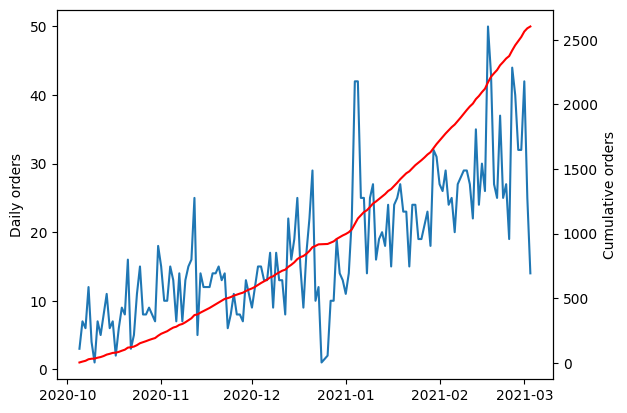

In [42]:
from matplotlib.axes import Axes
daily_orders = df_selected.groupby("order_date").order_id.nunique()
cumsum_daily_orders = daily_orders.cumsum()
fig , ax = plt.subplots()
ax: Axes
ax.plot(daily_orders, label="daily orders")
axi = ax.twinx()
axi.plot(cumsum_daily_orders,color='r', label="cumulative orders")
ax.set_ylabel("Daily orders")
axi.set_ylabel("Cumulative orders")



As previously stated in module 3, we will make a temporal split to prevent information leakeage.

In [43]:
cumsum_daily_orders = daily_orders.cumsum() / daily_orders.sum()

train_val_cutoff = cumsum_daily_orders[cumsum_daily_orders < 0.7].idxmax()
val_test_cutoff = cumsum_daily_orders[cumsum_daily_orders < 0.9].idxmax()
print("Train since:" , cumsum_daily_orders.index.min())
print("Train until:", train_val_cutoff)
print("Validation since:", train_val_cutoff)
print("Validation until:", val_test_cutoff)
print("Test since:", val_test_cutoff)
print("Test until:", cumsum_daily_orders.index.max())

Train since: 2020-10-05
Train until: 2021-02-04
Validation since: 2021-02-04
Validation until: 2021-02-22
Test since: 2021-02-22
Test until: 2021-03-03


In [44]:
train_df = df_selected[df_selected.order_date <= train_val_cutoff]
val_df = df_selected[(df_selected.order_date > train_val_cutoff) & (df_selected.order_date <= val_test_cutoff)]
test_df = df_selected[df_selected.order_date > val_test_cutoff]

In [51]:
def feature_label_split(df: pd.DataFrame, target: str) -> Tuple[pd.DataFrame, pd.Series]:
    return df.drop(columns=[target]), df[target]
X_train, y_train = feature_label_split(train_df, target)
X_val, y_val = feature_label_split(val_df, target)
X_test, y_test = feature_label_split(test_df, target)
train_cols = numerical_cols + binary_cols 

# Base Model

In order to know if we are following the right path, we will start by creating a simple model that will serve as a baseline and benchmark for future models.  we will take a simple predictor as the baseline(column: `Global popularity`). Since we are dealing with a binary classification problem (purchased or not purchased), the metrics used will be: Precision-Recall curve and AUC-ROC curve. The Precision-Recall curve it's a specially good metric to use when the classes are imbalanced, as is the case here. All these metrics are based on the famous confusion matrix.

In [71]:
def plot_metrics(
        model_name:str, y_pred:pd.Series, y_test:pd.Series,
        figure:Tuple[matplotlib.figure.Figure, np.array],
        log_loss_l:List[float], AP:List[float]
        =None
    ):
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    log_loss_l.append(log_loss(y_test, y_pred))
    AP.append(average_precision_score(y_test, y_pred))
    

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(17, 4))
    else:
        fig, ax = figure
    ax[0].plot(recall_, precision_, label=f"{model_name} (AUC = {pr_auc:.2f})")
    ax[0].set_xlabel("Recall")
    ax[0].set_ylabel("Precision")
    ax[0].set_title("Precision-Recall curve")
    ax[0].legend(loc="best")

    ax[1].plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_title("ROC curve")
    ax[1].legend(loc="best")



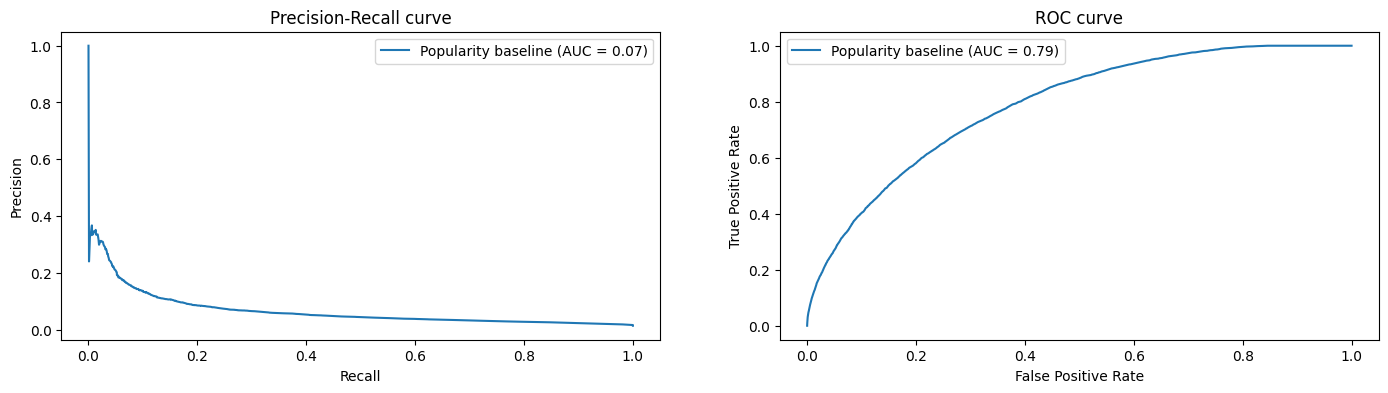

In [48]:
plot_metrics("Popularity baseline", y_pred=val_df["global_popularity"], y_test=val_df[target])

# Fitting models

## Random forest

RF with 5 trees: train log loss: 0.025, val log loss: 0.345, train AP: 0.770, val AP: 0.072
RF with 25 trees: train log loss: 0.021, val log loss: 0.251, train AP: 0.852, val AP: 0.111
RF with 50 trees: train log loss: 0.021, val log loss: 0.222, train AP: 0.859, val AP: 0.119
RF with 100 trees: train log loss: 0.021, val log loss: 0.190, train AP: 0.863, val AP: 0.125


Text(0.5, 1.0, 'Average precision vs n_estimators')

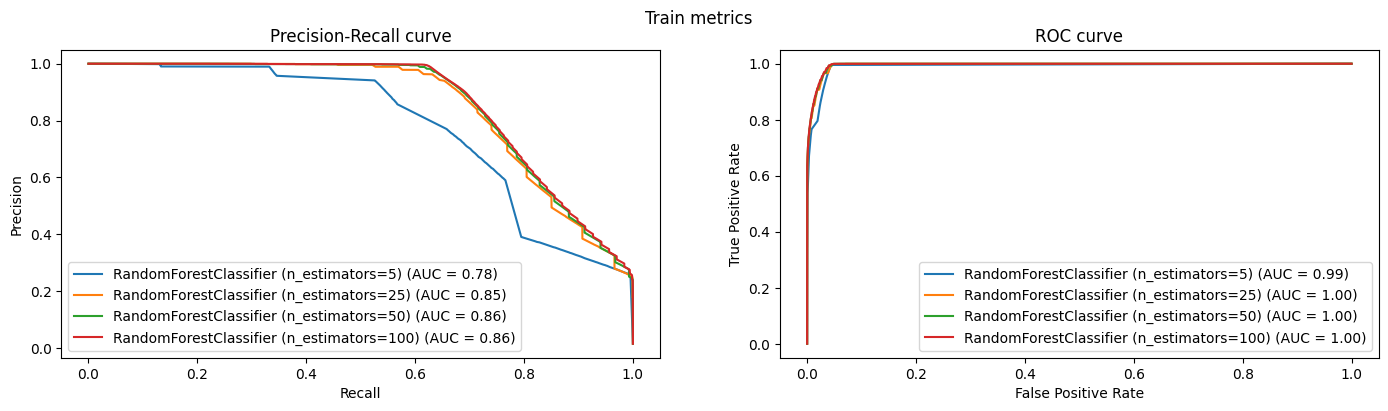

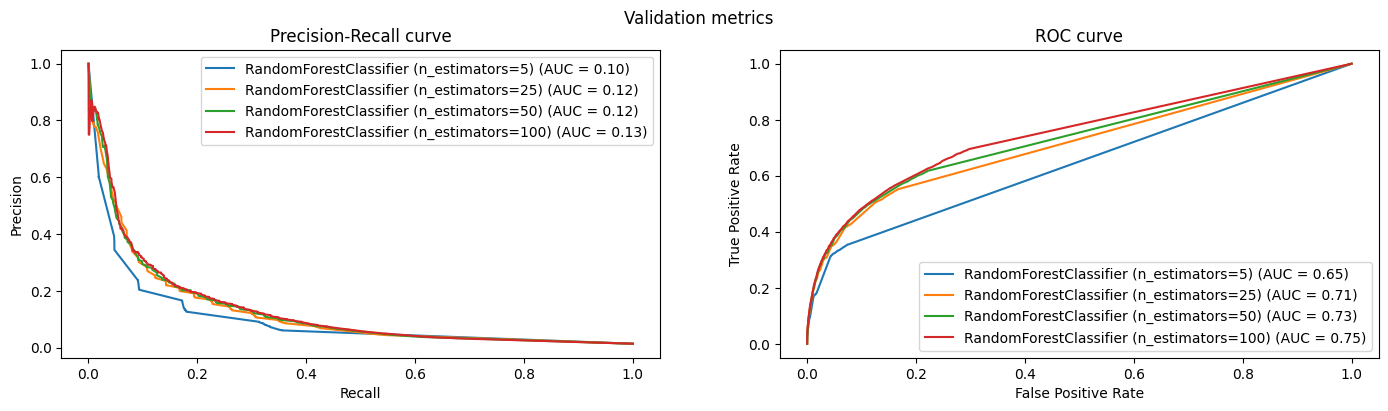

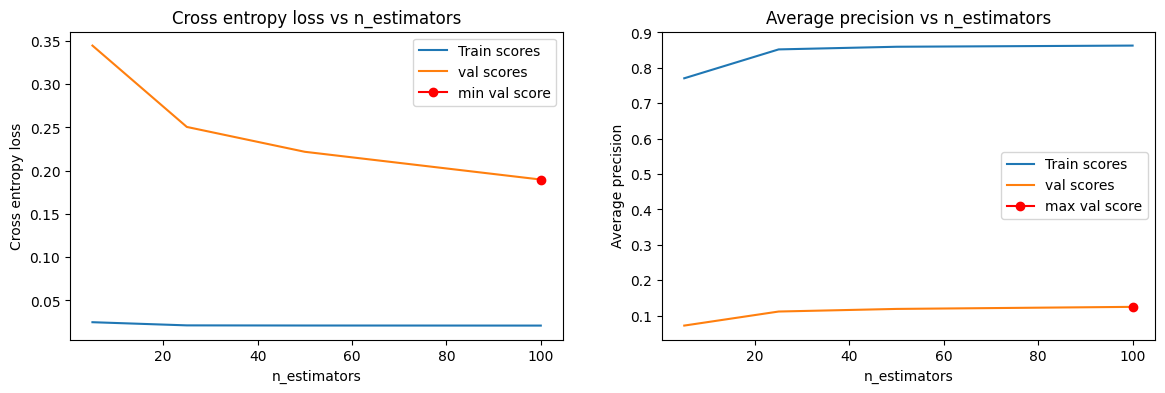

In [86]:
n_estimators = [5,25,50,100]
train_log_loss = []
val_log_loss = []
train_avg_precision = []
val_avg_precision = []

fig1, ax1 = plt.subplots(1, 2, figsize=(17, 4))
fig1.suptitle("Train metrics")
fig2, ax2 = plt.subplots(1, 2, figsize=(17, 4))
fig2.suptitle("Validation metrics")

for tree_size in n_estimators:
    model = RandomForestClassifier(
        n_estimators=tree_size,
        random_state=0,
        n_jobs=-1
    )
    model.fit(X_train[train_cols], y_train)
    train_proba = model.predict_proba(X_train[train_cols])[:, 1]
    plot_metrics(f"RandomForestClassifier (n_estimators={tree_size})", train_proba, y_train, (fig1, ax1), train_log_loss, train_avg_precision)
    val_proba = model.predict_proba(X_val[train_cols])[:, 1]  
    plot_metrics(f"RandomForestClassifier (n_estimators={tree_size})", val_proba, y_val, (fig2, ax2), val_log_loss, val_avg_precision)    
    print(f"RF with {tree_size} trees: train log loss: {train_log_loss[-1]:.3f}, val log loss: {val_log_loss[-1]:.3f}, train AP: {train_avg_precision[-1]:.3f}, val AP: {val_avg_precision[-1]:.3f}") 
   
fig, ax = plt.subplots(1,2,figsize=(14, 4))
ax[0].plot(n_estimators, train_log_loss, label= "Train scores")
ax[0].plot(n_estimators, val_log_loss, label= "val scores")
ax[0].plot(n_estimators[np.argmin(val_log_loss)], min(val_log_loss), 
        marker="o", color="r", label="min val score")
ax[0].set_ylabel("Cross entropy loss")
ax[0].set_xlabel("n_estimators")
ax[0].legend(loc="best")
ax[0].set_title("Cross entropy loss vs n_estimators")

ax[1].plot(n_estimators, train_avg_precision, label= "Train scores")
ax[1].plot(n_estimators, val_avg_precision, label= "val scores")
ax[1].plot(n_estimators[np.argmax(val_avg_precision)], max(val_avg_precision), 
        marker="o", color="r", label="max val score")
ax[1].set_ylabel("Average precision")
ax[1].set_xlabel("n_estimators")
ax[1].legend(loc="best")
ax[1].set_title("Average precision vs n_estimators")

- RF with better peformance are the ones with more trees. Let's keep the one with the most trees.

In [87]:
rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
rf.fit(X_train[train_cols], y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

<Axes: xlabel='importance', ylabel='features'>

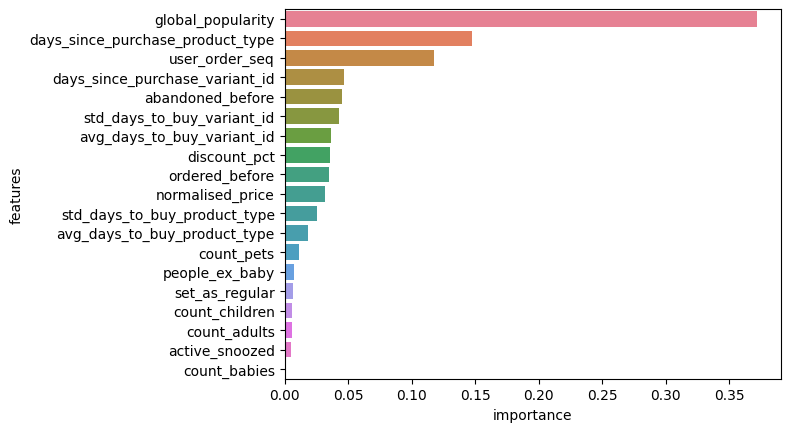

In [88]:
rf_importance_feautures = pd.DataFrame({"features": train_cols, "importance": rf.feature_importances_ }).sort_values("importance", ascending=False)
sns.barplot(data=rf_importance_feautures, x="importance", y="features", hue="features")

Let's remove the worst features and see if the model improves.

In [101]:
important_cols = rf_importance_feautures.features[:15].tolist()

RF with 5 trees: train log loss: 0.025, val log loss: 0.343, train AP: 0.769, val AP: 0.074
RF with 25 trees: train log loss: 0.021, val log loss: 0.252, train AP: 0.850, val AP: 0.109
RF with 50 trees: train log loss: 0.021, val log loss: 0.222, train AP: 0.858, val AP: 0.117
RF with 100 trees: train log loss: 0.021, val log loss: 0.193, train AP: 0.861, val AP: 0.122


Text(0.5, 1.0, 'Average precision vs n_estimators')

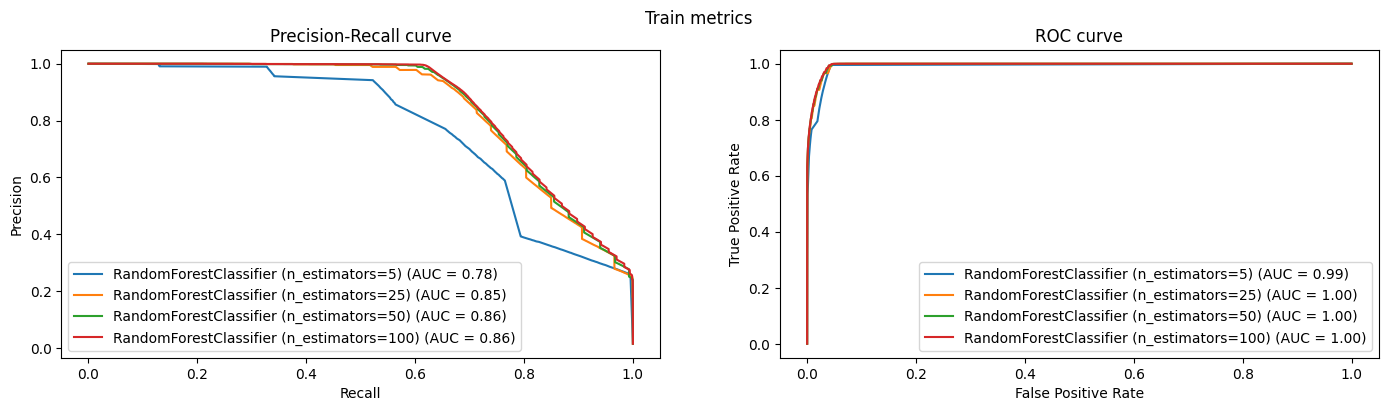

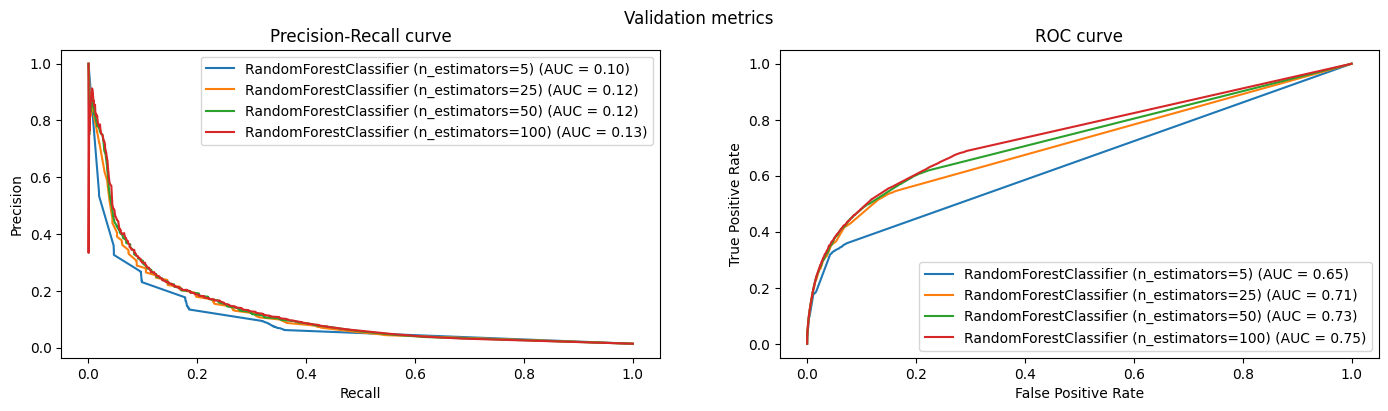

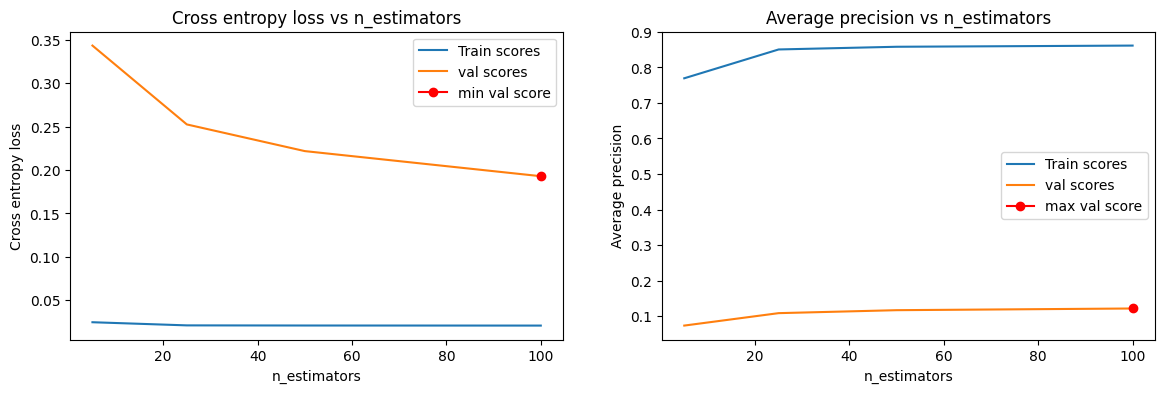

In [102]:
n_estimators = [5,25,50,100]
train_log_loss = []
val_log_loss = []
train_avg_precision = []
val_avg_precision = []

fig1, ax1 = plt.subplots(1, 2, figsize=(17, 4))
fig1.suptitle("Train metrics")
fig2, ax2 = plt.subplots(1, 2, figsize=(17, 4))
fig2.suptitle("Validation metrics")

for tree_size in n_estimators:
    model = RandomForestClassifier(
        n_estimators=tree_size,
        random_state=0,
        n_jobs=-1
    )
    model.fit(X_train[important_cols], y_train)
    train_proba = model.predict_proba(X_train[important_cols])[:, 1]
    plot_metrics(f"RandomForestClassifier (n_estimators={tree_size})", train_proba, y_train, (fig1, ax1), train_log_loss, train_avg_precision)
    val_proba = model.predict_proba(X_val[important_cols])[:, 1]  
    plot_metrics(f"RandomForestClassifier (n_estimators={tree_size})", val_proba, y_val, (fig2, ax2), val_log_loss, val_avg_precision)    
    print(f"RF with {tree_size} trees: train log loss: {train_log_loss[-1]:.3f}, val log loss: {val_log_loss[-1]:.3f}, train AP: {train_avg_precision[-1]:.3f}, val AP: {val_avg_precision[-1]:.3f}") 
   
fig, ax = plt.subplots(1,2,figsize=(14, 4))
ax[0].plot(n_estimators, train_log_loss, label= "Train scores")
ax[0].plot(n_estimators, val_log_loss, label= "val scores")
ax[0].plot(n_estimators[np.argmin(val_log_loss)], min(val_log_loss), 
        marker="o", color="r", label="min val score")
ax[0].set_ylabel("Cross entropy loss")
ax[0].set_xlabel("n_estimators")
ax[0].legend(loc="best")
ax[0].set_title("Cross entropy loss vs n_estimators")

ax[1].plot(n_estimators, train_avg_precision, label= "Train scores")
ax[1].plot(n_estimators, val_avg_precision, label= "val scores")
ax[1].plot(n_estimators[np.argmax(val_avg_precision)], max(val_avg_precision), 
        marker="o", color="r", label="max val score")
ax[1].set_ylabel("Average precision")
ax[1].set_xlabel("n_estimators")
ax[1].legend(loc="best")
ax[1].set_title("Average precision vs n_estimators")

- Removing the worst features, do not improve the performance of the model.

## GBT

Top 5 Models based on Validation Val AP:
max_iter=100, learning_rate=0.05, max_depth=10: train log loss: 0.060, val log loss: 0.056, train AP: 0.219, val AP: 0.197
max_iter=50, learning_rate=0.05, max_depth=10: train log loss: 0.061, val log loss: 0.056, train AP: 0.209, val AP: 0.196
max_iter=50, learning_rate=0.05, max_depth=5: train log loss: 0.062, val log loss: 0.056, train AP: 0.207, val AP: 0.195
max_iter=25, learning_rate=0.05, max_depth=10: train log loss: 0.063, val log loss: 0.057, train AP: 0.205, val AP: 0.195
max_iter=100, learning_rate=0.05, max_depth=5: train log loss: 0.061, val log loss: 0.056, train AP: 0.211, val AP: 0.195


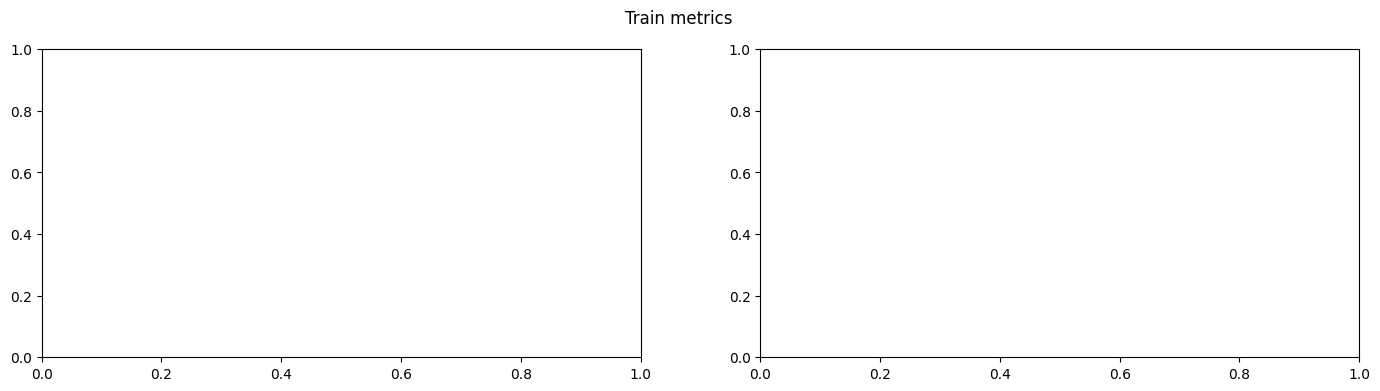

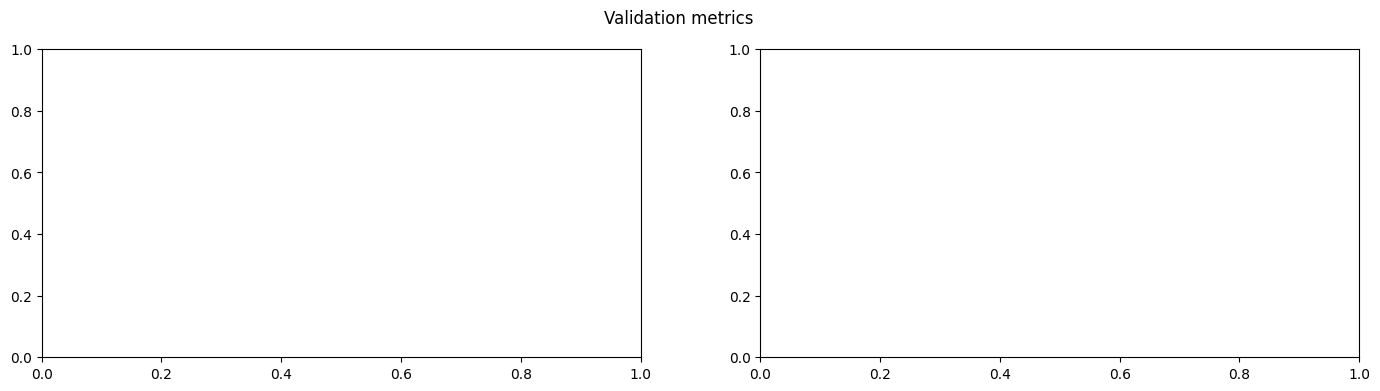

In [111]:
max_iter = [5, 10, 25, 50, 100]
lr = [0.01, 0.05, 0.1]
max_depth = [1, 5, 10]
train_log_loss = []
val_log_loss = []
train_avg_precision = []
val_avg_precision = []
model_performance=[]

fig1, ax1 = plt.subplots(1, 2, figsize=(17, 4))
fig1.suptitle("Train metrics")
fig2, ax2 = plt.subplots(1, 2, figsize=(17, 4))
fig2.suptitle("Validation metrics")

for max_iter in max_iter:
    for learning_rate in lr:
        for depth in max_depth:
            model = HistGradientBoostingClassifier(
                max_iter=max_iter,
                learning_rate=learning_rate,
                max_depth=depth,
                random_state=0
            )
            model.fit(X_train[train_cols], y_train)
            train_proba = model.predict_proba(X_train[train_cols])[:, 1]
            val_proba = model.predict_proba(X_val[train_cols])[:, 1]
            train_avg_precision.append(average_precision_score(y_train, train_proba))
            val_avg_precision.append(average_precision_score(y_val, val_proba))
            train_log_loss.append(log_loss(y_train, train_proba))
            val_log_loss.append(log_loss(y_val, val_proba))
            model_performance.append({
                'model': f"max_iter={max_iter}, learning_rate={learning_rate}, max_depth={depth}",
                'train_log_loss': train_log_loss[-1],
                'val_log_loss': val_log_loss[-1],
                'train_avg_precision': train_avg_precision[-1],
                'val_avg_precision': val_avg_precision[-1]
            })
# Sort the models based on validation AP (descending, since higher AP is better)
sorted_models = sorted(model_performance, key=lambda x: x['val_avg_precision'],reverse=True)
print("Top 5 Models based on Validation Val AP:")
for model_info in sorted_models[:5]:
    print(f"{model_info['model']}: train log loss: {model_info['train_log_loss']:.3f}, val log loss: {model_info['val_log_loss']:.3f}, train AP: {model_info['train_avg_precision']:.3f}, val AP: {model_info['val_avg_precision']:.3f}")
    